In [13]:
#%matplotlib inline
%matplotlib notebook

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

random.seed(0)

In [4]:
def rand_delay():
    """
    Generate a random delay between 0 and 10 ms, in steps of 625 us.
    """
    
    STEP = 625 / 1000 
    MAX = 10 / STEP
    MIN = 0

    #print(MIN, MAX, STEP)
    
    return random.randint(MIN, MAX) * STEP

<IPython.core.display.Javascript object>


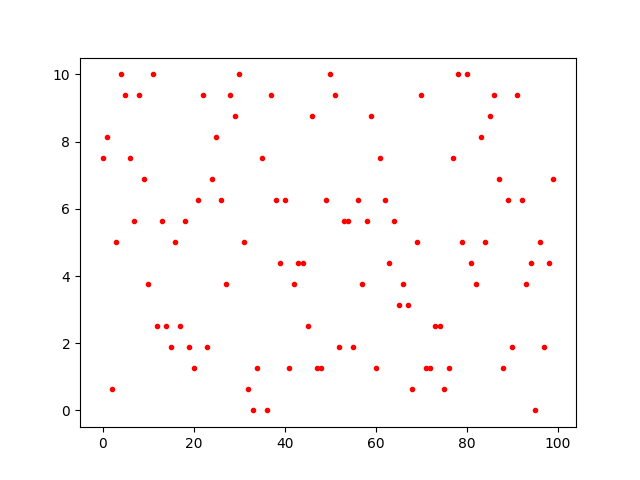

In [5]:
test = []
for i in range(100):
    test.append(rand_delay())
    
fig, ax = plt.subplots()
ax.plot(test, 'r.')

In [82]:
# The size of the advertisement packet on BLE 4.2 is
# (https://www.rfwireless-world.com/Terminology/BLE-Advertising-and-Data-Packet-Format.html):
# Preamble               1 Byte
# Access Address         4 Bytes
# Advertisement Header   2 bytes
# Payload (2-37):       14 Bytes on Elisa's configuration
# CRC:                   3 Bytes
# Total                 24 Bytes

payload_size = 14
adv_size = (1 + 4 + 2 + payload_size + 3) * 8 # bits
data_rate = 1000 # 1 Mbps = 1000000 bits/s = 1000 bits/ms
adv_airtime = adv_size / data_rate

def simulate(num_devices, period, n_frames, debug=False):
    devices = []
    for i in range(num_devices):
        # Select a random "boot time" for each device.
        start_time = random.randint(0, period)
        
        # Generate the transmission time for each of the advertisements, one transmission time every period plus a random
        # delay between 0 and 10ms.
        device = np.array([x * period + rand_delay() for x in range(0, n_frames)]) + start_time
        devices.append(device)
    
    if debug == True:
        print(devices)

    # Collisions stores the advertisements in collision. 1 means that the there was a collision with the 
    # corresponding advertisement. Start with all the array set to 0, then loop over the devices comparing the
    # transmission times to check for collisions
    collisions = np.zeros_like(devices)

    for i in range(len(devices)):
        j = i + 1
        while j < len(devices):
            if debug == True:
                print(abs(devices[i] - devices[j]))

            # If the time between two frames is below the frame airtime, then a collision happened. Assume that both frames
            # are lost, thus, mark the two frames involved with 1
            collisions[i] = np.where(abs(devices[i] - devices[j]) < adv_airtime, 1, collisions[i])
            collisions[j] = np.where(abs(devices[i] - devices[j]) < adv_airtime, 1, collisions[j])

            j += 1

    percentage_lost = collisions.sum() / collisions.size * 100

    return percentage_lost

In [83]:
simulate(2, 100, 10, debug=True)

[array([ 72.75 , 167.75 , 271.5  , 370.25 , 464.   , 564.625, 672.125,
       772.75 , 865.25 , 971.5  ]), array([ 35.75 , 133.875, 240.75 , 336.375, 432.   , 532.   , 633.875,
       740.125, 835.125, 934.5  ])]
[37.    33.875 30.75  33.875 32.    32.625 38.25  32.625 30.125 37.   ]


0.0

<IPython.core.display.Javascript object>


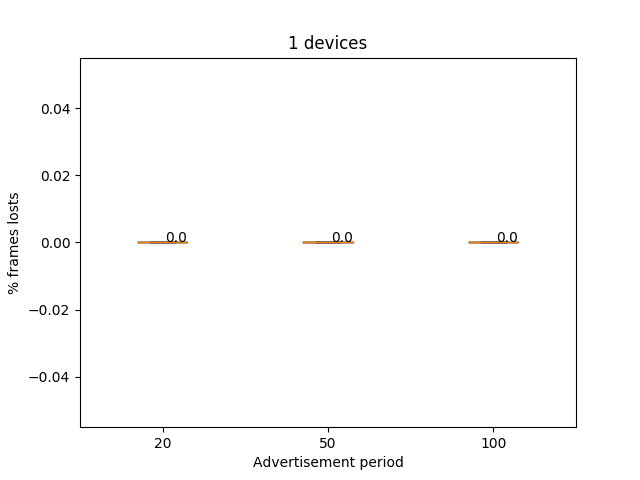

<IPython.core.display.Javascript object>


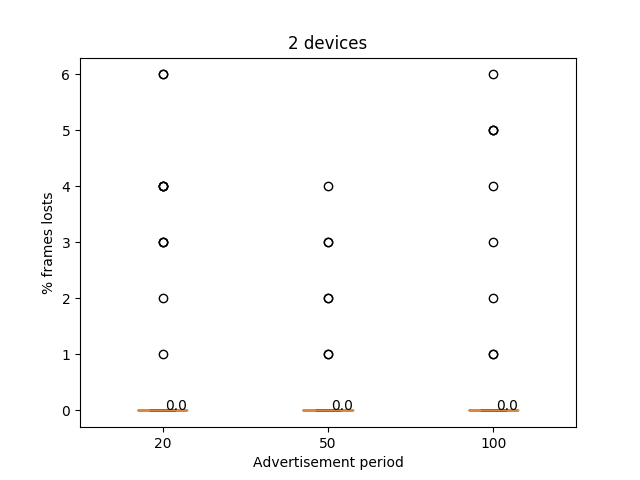

<IPython.core.display.Javascript object>


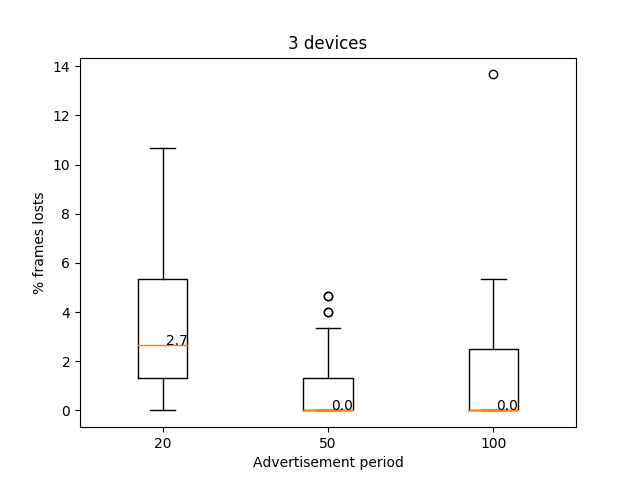

<IPython.core.display.Javascript object>


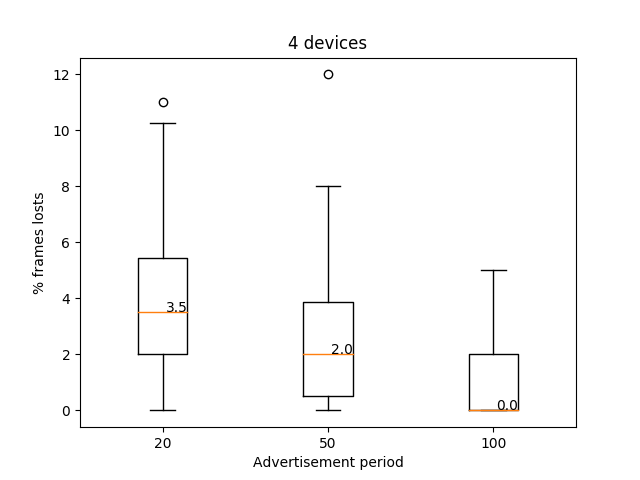

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


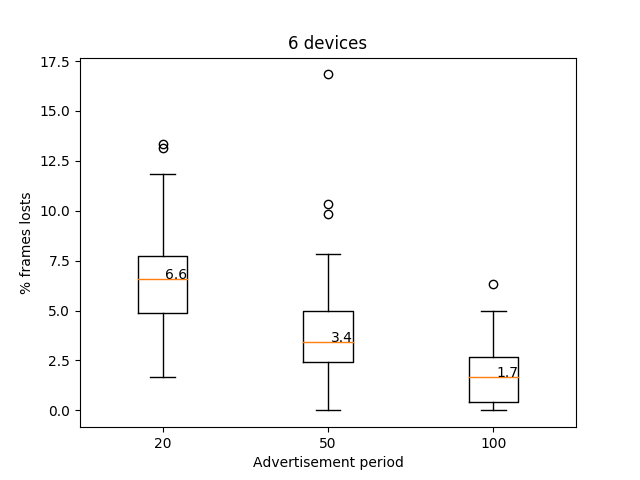

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


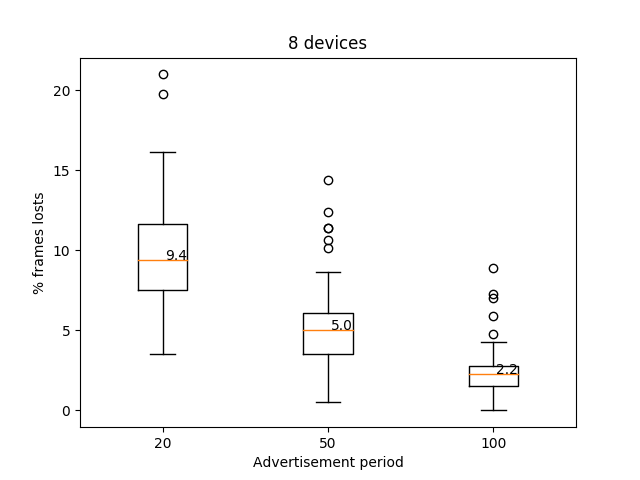

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


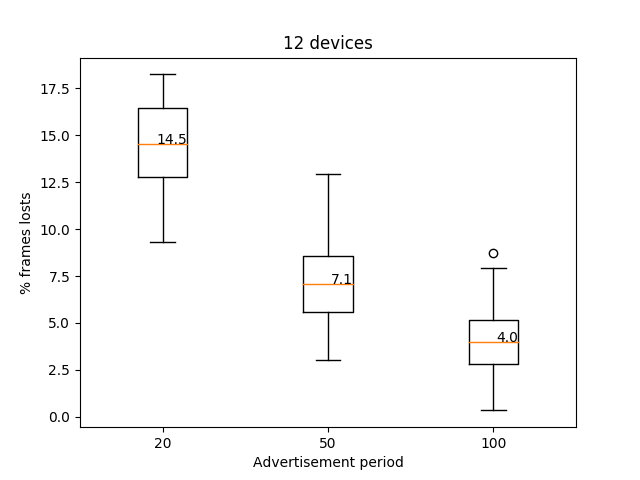

<IPython.core.display.Javascript object>


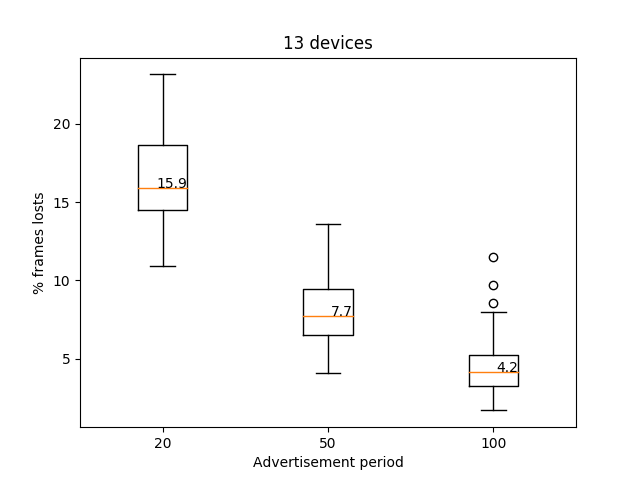

<IPython.core.display.Javascript object>


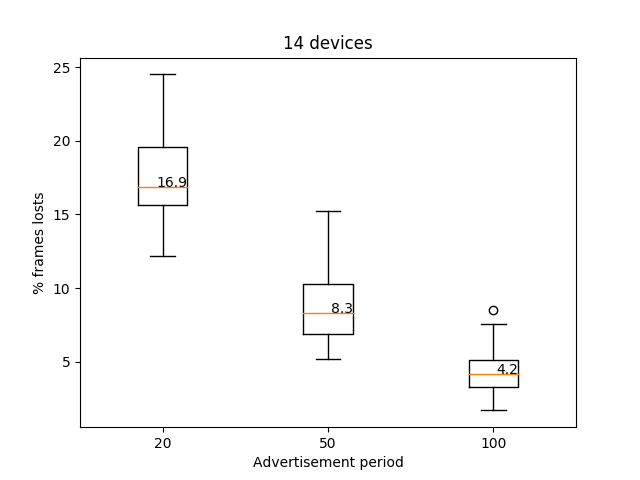

<IPython.core.display.Javascript object>


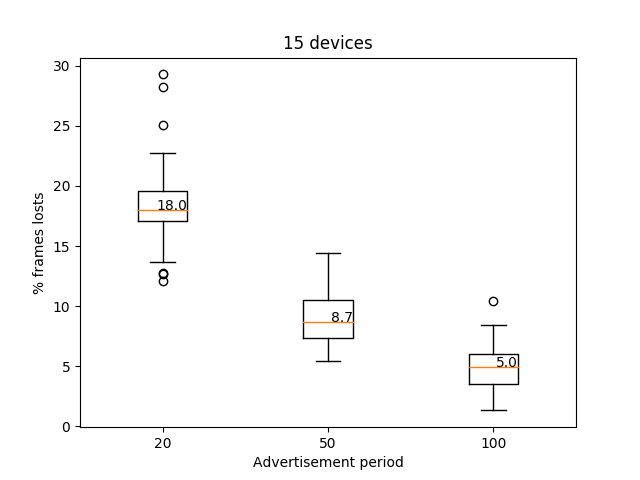

<IPython.core.display.Javascript object>


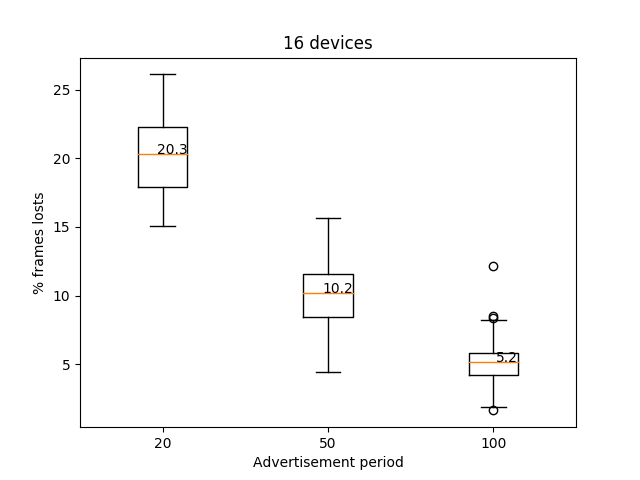

<IPython.core.display.Javascript object>


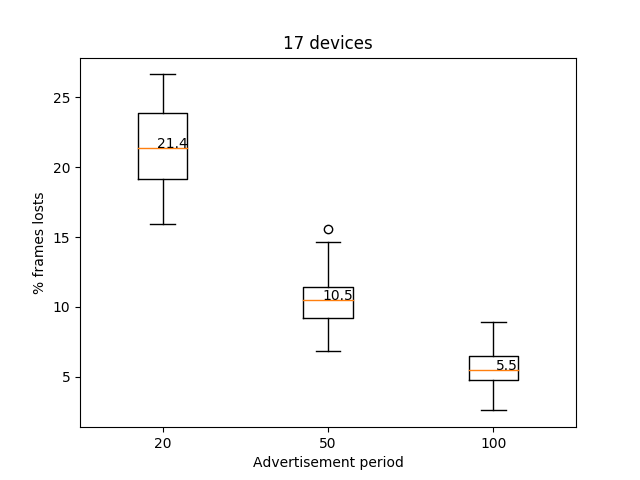

<IPython.core.display.Javascript object>


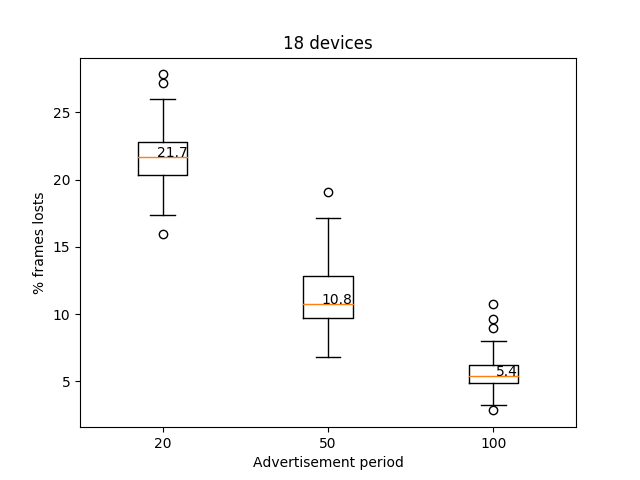

<IPython.core.display.Javascript object>


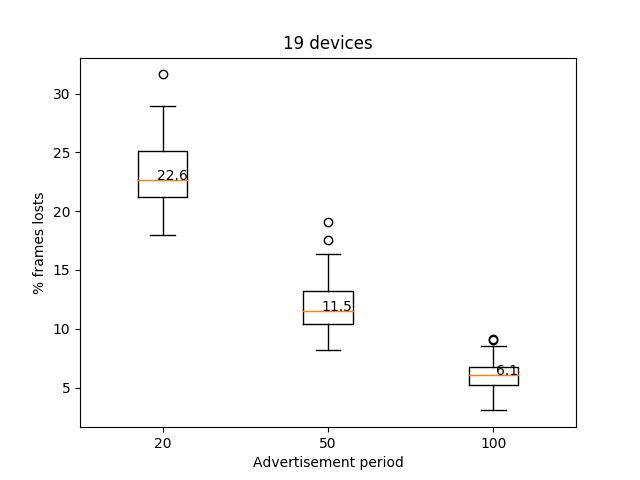

<IPython.core.display.Javascript object>


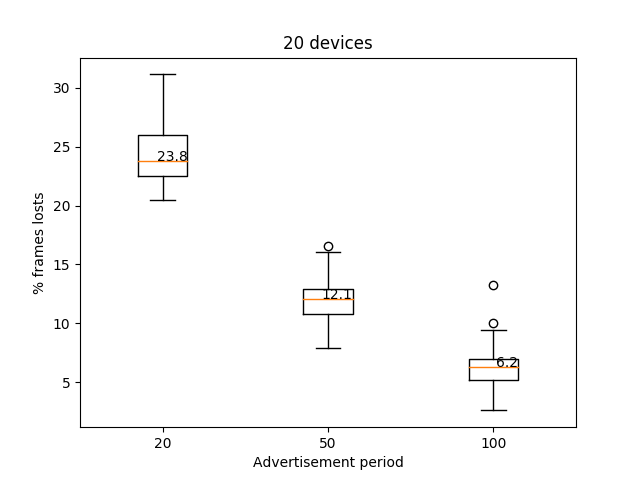

In [160]:
#DEVICES = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60, 80, 100)
DEVICES = range(1, 21, 1)
PERIODS = (20, 50, 100)#range(10, 100, 20)
TRIALS = 50

plt.close('all')
trials = {}
for num_devices in DEVICES:
    trials[num_devices] = {}
    for period in PERIODS:
        trials[num_devices][period] = []
        for trial in range(TRIALS):
            trials[num_devices][period].append(simulate(num_devices, period, 100))
    
    fig, ax = plt.subplots()
    ax.set_title('{} devices'.format(num_devices))
    ax.set_ylabel('% frames losts')
    ax.set_xlabel('Advertisement period')
    bp_dict = ax.boxplot(trials[num_devices].values(), labels=trials[num_devices].keys())
    
    for line in bp_dict['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        ax.text(x, y, '%.1f' % y,
             horizontalalignment='right')

    #print(trials[num_devices][period])


<IPython.core.display.Javascript object>


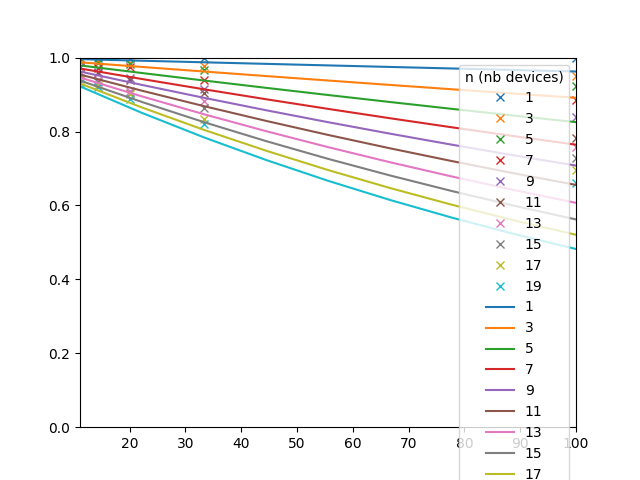

             1         3      5         7         9         11        13  \
100.000000  1.0  0.950000  0.922  0.885000  0.840000  0.783182  0.756923   
33.333333   1.0  0.976667  0.967  0.938571  0.914444  0.904545  0.882692   
20.000000   1.0  0.986667  0.984  0.975714  0.945556  0.939545  0.909231   
14.285714   1.0  0.990000  0.986  0.972857  0.962222  0.957273  0.940000   
11.111111   1.0  1.000000  0.992  0.974286  0.974444  0.956818  0.956154   

                  15        17        19  
100.000000  0.727333  0.694706  0.659474  
33.333333   0.864333  0.834118  0.821316  
20.000000   0.904333  0.901176  0.888158  
14.285714   0.934000  0.924706  0.921316  
11.111111   0.944667  0.940882  0.932368  


In [92]:
df = pd.DataFrame(trials)

fig, ax = plt.subplots()
ax.set_ylim([0, 1])

frames_per_sec = dict(zip(df.index, 1 / df.index *1000))
print(1 - df.rename(index=frames_per_sec).applymap(np.median)/100)
(1 - df.rename(index=frames_per_sec).applymap(np.median)/100).plot(ax=ax, marker='x', linestyle='None')


In [93]:
# Aloha model

#l=256.0 -> adv_size
D=10**6
T=adv_size/D

#fig, ax = plt.subplots()
#ax.set_xlabel('$f$: nb frame/s')
#ax.set_ylabel('$P_s$: probability of success')
#ax.set_ylim([0, 1])
f = np.linspace(0,100,10)

for n in range(1,20,2):
    g = n*f
    Ps = np.exp(-2*g*T)
    
    ax.plot(f, Ps, label=n)

ax.legend(title='n (nb devices)',
          #loc="best",
          #bbox_to_anchor=(1.3,1),
          #shadow=True,
          #fancybox=True
)



In [ ]:
(1 - df.rename(index=frames_per_sec).applymap(np.median)/100)

<IPython.core.display.Javascript object>


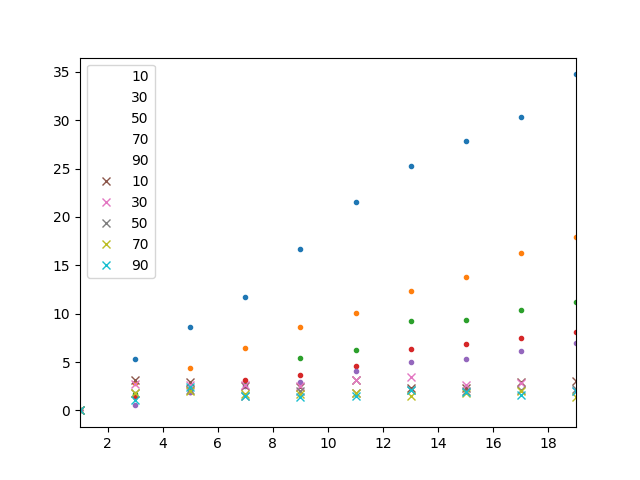

In [103]:
fig, ax = plt.subplots()
df.unstack().apply(np.mean).unstack().plot(marker='.', linestyle='None', ax=ax)
df.unstack().apply(np.std).unstack().plot(marker='x', linestyle='None', ax=ax)

#df.unstack().apply([np.mean, np.std]).plot(ax=ax, marker='.')

In [117]:
df2 = df.unstack().apply(np.mean).reset_index()

In [119]:
df3 = df.unstack().apply(np.std).reset_index()

In [129]:
df2.columns = ['devices', 'period', 'mean']
df3.columns = ['devices', 'period', 'std']

In [146]:
pd.concat([df2, df3], axis=1)

devices  period       mean  devices  period       std
0         1      10   0.000000        1      10  0.000000
1         1      30   0.000000        1      30  0.000000
2         1      50   0.000000        1      50  0.000000
3         1      70   0.000000        1      70  0.000000
4         1      90   0.000000        1      90  0.000000
5         3      10   5.266667        3      10  3.126233
6         3      30   2.883333        3      30  2.753331
7         3      50   1.733333        3      50  1.756259
8         3      70   1.366667        3      70  1.807085
9         3      90   0.533333        3      90  1.087300
10        5      10   8.600000        5      10  2.940748
11        5      30   4.390000        5      30  2.642329
12        5      50   2.230000        5      50  2.144085
13        5      70   1.920000        5      70  1.970178
14        5      90   1.870000        5      90  2.461118
15        7      10  11.685714        7      10  2.480783
16        7      30   6.464286        7      30  2.655328
17        7      50   2.678571        7      50  1.500255
18        7      70   3.128571        7      70  1.664700
19        7      90   2.571429        7      90  1.503058
20        9      10  16.688889        9      10  2.425329
21        9      30   8.627778        9      30  2.554414
22        9      50   5.411111        9      50  1.968612
23        9      70   3.666667        9      70  1.657382
24        9      90   2.888889        9      90  1.384660
25       11      10  21.545455       11      10  3.120977
26       11      30  10.072727       11      30  3.133873
27       11      50   6.259091       11      50  1.826181
28       11      70   4.613636       11      70  1.801715
29       11      90   4.122727       11      90  1.496905
30       13      10  25.226923       13      10  2.295155
31       13      30  12.342308       13      30  3.459613
32       13      50   9.196154       13      50  2.078557
33       13      70   6.369231       13      70  1.521755
34       13      90   4.957692       13      90  2.094438
35       15      10  27.860000       15      10  2.332848
36       15      30  13.836667       15      30  2.658109
37       15      50   9.370000       15      50  1.963045
38       15      70   6.860000       15      70  1.839191
39       15      90   5.360000       15      90  1.920231
40       17      10  30.347059       17      10  2.908995
41       17      30  16.244118       17      30  2.858743
42       17      50  10.373529       17      50  2.084651
43       17      70   7.488235       17      70  2.010707
44       17      90   6.105882       17      90  1.586884
45       19      10  34.731579       19      10  3.042219
46       19      30  17.939474       19      30  2.000019
47       19      50  11.160526       19      50  2.182052
48       19      70   8.105263       19      70  1.391307
49       19      90   7.013158       19      90  1.986511

In [149]:
real_tests = {
    1: {
        20: 0.17,
        50: 0.1,
        100: 0.19,
    },
    2: {
        20: 1.58,
        50: 0.9,
        100: 0.56,
    },
    3: {
        20: 2.76, 
        50: 1.79, 
        100: 1.5,
    },
    4: {
        20: 3.7,
        50: 1.82,
        100: 1.1,
    },
    5: {
        20: 4.63, 
        50: 3.87,
        100: 1.76,
    },
    6: {
        20: 5.85,
        50: 3.5,
        100: 2.15,
    },
}

In [154]:
real_tests = pd.DataFrame(real_tests)
print(real_tests)

        1     2     3     4     5     6
20   0.17  1.58  2.76  3.70  4.63  5.85
50   0.10  0.90  1.79  1.82  3.87  3.50
100  0.19  0.56  1.50  1.10  1.76  2.15


In [162]:
fig, ax = plt.subplots()

real_tests.plot(ax=ax, marker='.', linestyle='None')
ax.set_ylim([-1, 7])
ax.set_xlim([10, 110])
ax.grid()

/home/lmolina/venvs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [158]:
df

1   \
10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
30  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
50  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
70  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
90  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                   3   \
10  [4.666666666666667, 13.0, 2.0, 8.6666666666666...   
30  [1.3333333333333335, 3.3333333333333335, 6.666...   
50  [0.0, 0.0, 3.3333333333333335, 0.0, 0.66666666...   
70  [1.3333333333333335, 3.3333333333333335, 1.333...   
90  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, ...   

                                                   5   \
10  [6.800000000000001, 9.2, 4.0, 5.2, 7.399999999...   
30  [3.2, 5.6000000000000005, 4.8, 7.1999999999999...   
50  [6.2, 2.4, 0.8, 3.2, 3.2, 0.0, 2.8000000000000...   
70  [0.0, 5.2, 1.2, 0.0, 4.8, 0.4, 0.0, 5.60000000...   
90  [2.4, 0.0, 0.4, 8.6, 0.8, 2.0, 1.6, 0.0, 2.0, ...   

                                                   7   \
10  [13.142857142857142, 14.285714285714285, 11.42...   
30  [4.285714285714286, 8.0, 6.2857142857142865, 4...   
50  [1.1428571428571428, 3.1428571428571432, 3.142...   
70  [3.1428571428571432, 2.857142857142857, 7.4285...   
90  [1.7142857142857144, 3.428571428571429, 2.5714...   

                                                   9   \
10  [15.11111111111111, 13.444444444444445, 15.555...   
30  [10.666666666666668, 10.666666666666668, 8.333...   
50  [2.4444444444444446, 2.0, 3.3333333333333335, ...   
70  [0.8888888888888888, 1.5555555555555556, 7.333...   
90  [2.2222222222222223, 4.666666666666667, 4.0, 2...   

                                                   11  \
10  [18.0, 26.272727272727277, 18.09090909090909, ...   
30  [9.272727272727273, 9.272727272727273, 5.45454...   
50  [5.636363636363637, 8.818181818181818, 4.54545...   
70  [5.7272727272727275, 2.181818181818182, 2.7272...   
90  [6.636363636363636, 4.454545454545455, 2.36363...   

                                                   13  \
10  [25.846153846153847, 22.30769230769231, 26.615...   
30  [12.0, 7.538461538461538, 12.230769230769232, ...   
50  [7.846153846153846, 10.538461538461538, 8.6923...   
70  [5.384615384615385, 7.6923076923076925, 5.6923...   
90  [2.076923076923077, 2.4615384615384617, 2.6153...   

                                                   15  \
10  [32.2, 26.8, 24.066666666666666, 27.0, 28.7999...   
30  [11.133333333333335, 12.133333333333333, 14.46...   
50  [6.0, 9.533333333333333, 9.6, 9.0, 6.933333333...   
70  [6.7333333333333325, 4.933333333333334, 7.1333...   
90  [5.466666666666667, 6.333333333333334, 8.93333...   

                                                   17  \
10  [29.294117647058826, 29.88235294117647, 30.0, ...   
30  [19.0, 15.11764705882353, 11.294117647058824, ...   
50  [7.0588235294117645, 14.76470588235294, 8.2352...   
70  [10.058823529411764, 7.529411764705881, 4.7058...   
90  [4.941176470588235, 5.764705882352941, 6.70588...   

                                                   19  
10  [32.73684210526316, 37.42105263157895, 34.7368...  
30  [19.105263157894736, 23.105263157894736, 18.36...  
50  [10.947368421052632, 12.0, 11.789473684210526,...  
70  [7.7894736842105265, 9.421052631578947, 6.0, 7...  
90  [6.7368421052631575, 7.210526315789474, 6.8947...